In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import metrics

from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
# 标签值为用户的活动类型
X_train = np.loadtxt("1.0X_train.txt")
y_train = np.loadtxt("1.0y_train.txt").astype(int)

X_test = np.loadtxt("1.0X_test.txt")
y_test = np.loadtxt("1.0y_test.txt").astype(int)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7352, 561), (2947, 561), (7352,), (2947,))

In [3]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

X.shape, y.shape

((10299, 561), (10299,))

In [4]:
# np.vstack:按垂直方向（行顺序）堆叠数组构成一个新的数组
a = np.array([[1,2,3], [4,5,6]])

b = np.array([[7,8,9], [10,11,12]])

c = np.vstack((a,b)) # 将两个（2,3）形状的数组按垂直方向叠加
print(c.shape)
c

(4, 3)


array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [5]:
# np.vstack等同于np.concatenate([], axis=0)
np.concatenate([a, b], axis=0)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [6]:
# np.hstack:按水平方向（列顺序）堆叠数组构成一个新的数组
a = np.array([[1,2,3], [4,5,6]])

b = np.array([[7,8,9], [10,11,12]])

c2 = np.hstack((a,b)) # 将两个（2,3）形状的数组按水平方向叠加
print(c2.shape)
c2

(2, 6)


array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

In [7]:
# np.hstack等同于np.concatenate([], axis=1)
np.concatenate([a, b], axis=1)

array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]])

In [8]:
# 查看标签数据中唯一值有哪些，并得到数据集目标类别的数量 n_classes
n_classes = np.unique(y).size
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
# 使用 StandardScaler 完成特征数据的规范化，注意是对每一个特征维度去均值+方差归一化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(10299, 561)

In [10]:
RANDOM_STATE=5  # 设定好随机种子，避免后续重跑出现不同的结果
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)     
# n_components 可以是小数、也可以是整数，小数-设置降维后的数据所能保留的信息比例，整数-设置主成分的个数
# PCA主成分数量k的选择，是一个数据压缩的问题。
# 通常我们直接将参数n_components设置为float数据，来间接解决k值选取的问题

X_pca = pca.transform(X_scaled)
X_pca.shape

(10299, 65)

In [11]:
round(float(pca.explained_variance_ratio_[0] * 100))

51

In [12]:
round(float(pca.explained_variance_ratio_[1] * 100))

6

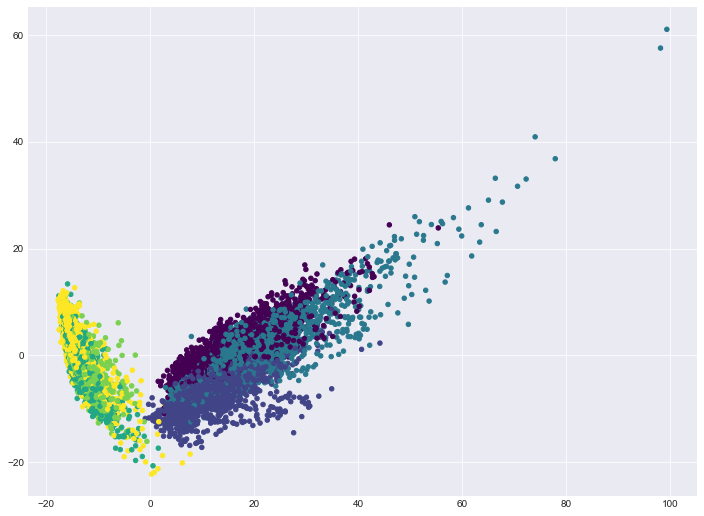

In [13]:
# 将第一主成分与第二主成分的分布呈现在二维图中，点的颜色对应实际所属的类型（y）
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.show()

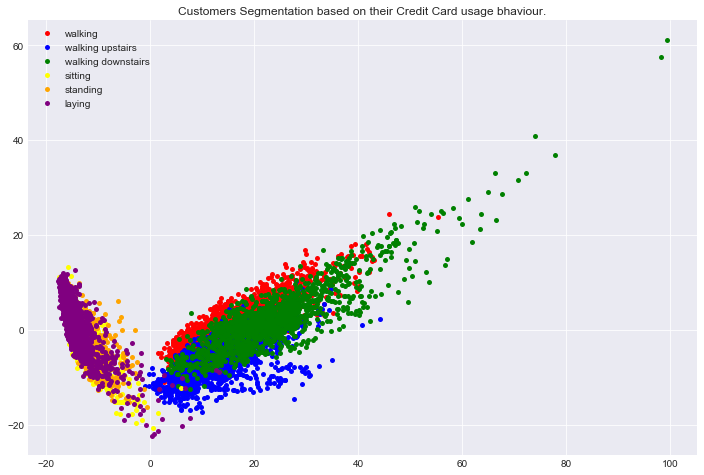

In [14]:
# 更好的画图方法，就是不同类型（y）的样本点对应不同的颜色
xx1, xx2 = X_pca[:, 0], X_pca[:, 1]

colors = {1: 'red',
          2: 'blue',
          3: 'green', 
          4: 'yellow', 
          5: 'orange',  
          6: 'purple'}

names = {1: 'walking',
         2: 'walking upstairs',
         3: 'walking downstairs', 
         4: 'sitting', 
         5: 'standing',  
         6: 'laying'}
  
df = pd.DataFrame({'x': xx1, 'y':xx2, 'label':y}) 
groups = df.groupby('label')            # 所以先要得到一个dataframe，前两列分别是第一、第二主成分，第三列是实际类别

fig, ax = plt.subplots(figsize=(12, 8)) 

for name, group in groups:             # 遍历每一类，这样的话，label与color一一对应，例如类别为walking的样本点就是红色的
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=n_classes, n_init=100,
                random_state=RANDOM_STATE, n_jobs=1)
kmeans.fit(X_pca)
# n_init 用不同的初始化质心运行算法的次数。
# 由于K-Means是结果受初始值影响的局部最优的迭代算法，因此需要多跑几次以选择一个较好的聚类效果，默认是10

cluster_labels = kmeans.labels_
# 每个样本点对应的分类

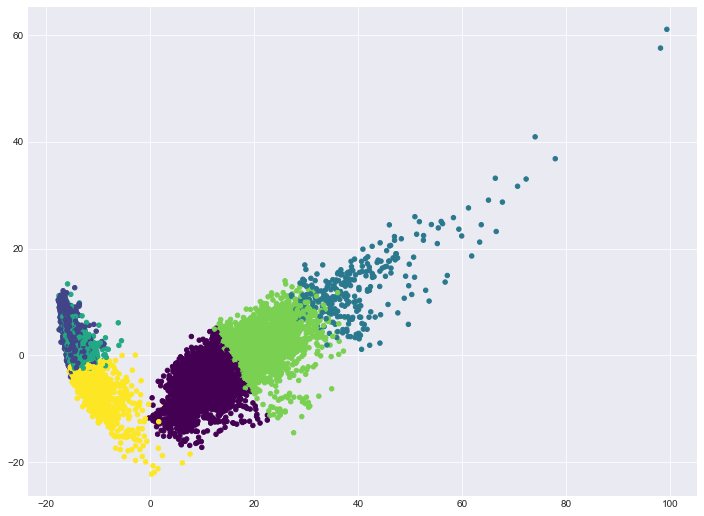

In [16]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.show()

In [17]:
# 实际标签值
print(len(y))
y[:50]

10299


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [18]:
# 聚类标签值
print(len(cluster_labels))
cluster_labels [:50]
# 注意聚类标签值的0-5与实际标签值1-6在数值上没有对应关系，聚类标签值的0-5只是用来区分那6个簇的

10299


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 5, 5, 3, 5, 5, 5, 5, 1, 1, 1, 1, 5, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [19]:
# 使用pd.crosstab按照原始活动类别标签和聚类标签统计分组的频数
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,904,0,78,0,740,0,1722
going up the stairs,1241,0,5,0,296,2,1544
going down the stairs,320,0,196,0,890,0,1406
sitting,1,90,0,1235,0,451,1777
standing,0,0,0,1344,0,562,1906
laying,5,1556,0,53,0,330,1944
all,2471,1646,279,2632,1926,1345,10299


In [20]:
pd.Series(tab.iloc[:-1, :-1].max(axis=1).values /
          tab.iloc[:-1, -1].values, index=tab.index[:-1]).sort_values()

walking                  0.524971
going down the stairs    0.633001
sitting                  0.694992
standing                 0.705142
laying                   0.800412
going up the stairs      0.803756
dtype: float64

In [21]:
ts=pd.DataFrame([[1,2,3],[4,5,6]])
print(ts.max(axis=1))   # 每行的max
print(ts.max(axis=0))   # 每列的max
print(ts.max(axis=1).values/ts.iloc[:, -1].values)   # 相当于每行的max分别除以每行的最后一个数

0    3
1    6
dtype: int64
0    4
1    5
2    6
dtype: int64
[1. 1.]


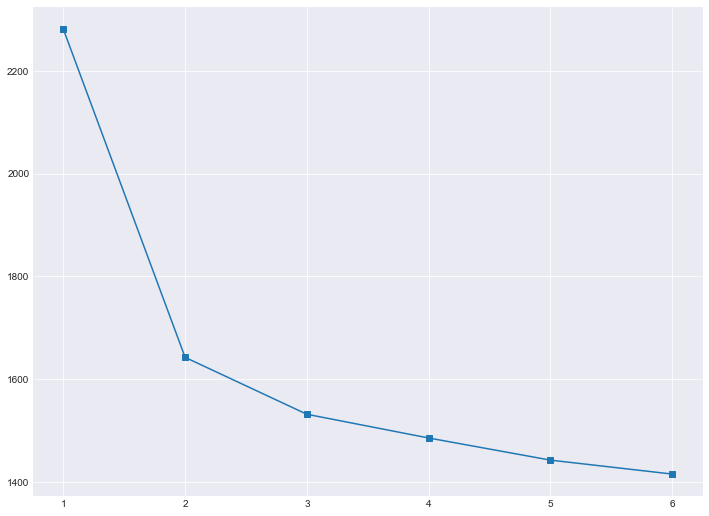

In [22]:
# 聚类的 K值遍历1-6，通过观察 K-类内离差平方和的开方根 的折线图与肘部法则，选择较合适的 K值
# tqdm_notebook可以以进度条的形式查看计算的过程
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100,
                    random_state=RANDOM_STATE, n_jobs=1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))     # kmeans.inertia_每个点到其簇质心的距离平方和，即类内离差平方和；越小越好 
    

plt.plot(range(1, 7), inertia, marker='s')
plt.show()

In [23]:
kmeans2 = KMeans(n_clusters=2, n_init=100,
                    random_state=RANDOM_STATE, n_jobs=1).fit(X_pca)
cluster_labels2 = kmeans2.labels_

# 查看原始类别下的样本聚类后的分散程度
tab2 = pd.crosstab(y, cluster_labels2, margins=True)
tab2.index = ['walking', 'going up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab2.columns = ['cluster' + str(i + 1) for i in range(2)] + ['all']
tab2

# 这样就很清晰了，前3大类的样本基本均聚集在第2个簇，后3大类的样本基本均聚集在第1个簇；
# 虽然一个簇里包含3个原始大类的样本，但目前就不存在原始大类下的样本分散在不同簇里的情况了。
# 所以目前这个聚类结果，虽然不能精确到每个原始大类，但是可以较准确地将前3大类的样本和后3大类的样本分开，比上面的K=6的聚类结果要来得清晰。

,cluster1,cluster2,all
walking,0,1722,1722
going up the stairs,8,1536,1544
going down the stairs,0,1406,1406
sitting,1774,3,1777
standing,1906,0,1906
laying,1932,12,1944
all,5620,4679,10299


聚类结果的可视化

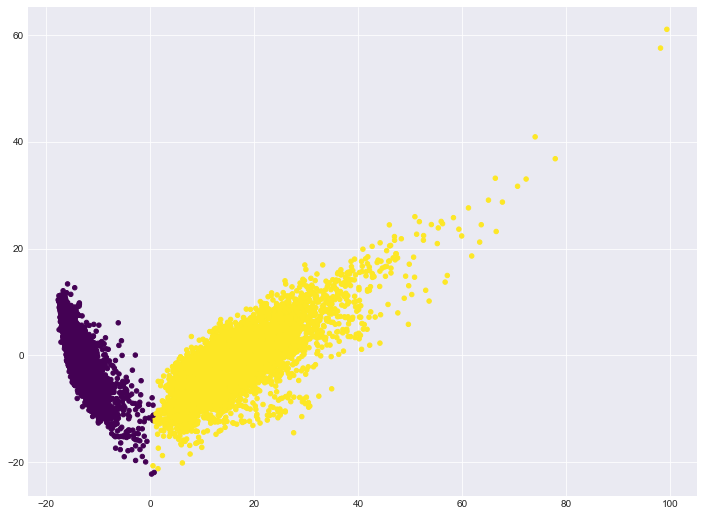

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels2, s=20, cmap='viridis')
plt.show()

In [25]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [26]:
d

{2: 0.17344753560094145,
 3: 0.4168850652642453,
 4: 0.9332222532341972,
 5: 0.6296957877424777}